In [1]:
import os

import audio_dspy as adsp
import matplotlib as mpl
import matplotlib.pyplot as plt
import wavio

#debugging
import numpy as np
from scipy.interpolate import interp2d
import scipy.stats as stats

In [2]:
# obj_name = 'CeramicMug'
obj_name = '9_BowlCeramic_fullsweep'
fs = 48000
deconvolved = np.load(os.path.join('/viscam/projects/realimpact/sweeps/', obj_name, 'preprocessed/deconvolved.npy'))

# DSP to find modes and dampings

In [3]:
def find_freqs(x, fs, thresh=30, above=0, frac_off=0.1, plot=False):
    """
    Find the mode frequencies of a signal
    Parameters
    ----------
    x : ndarray
        signal to analyze
    fs : float
        sample rate of the signal
    thresh : float, optional
        threshold to use for finding modes [dB]
    above : float, optional
        lower limit frequency to look for modes
    frac_off : float, optional
        to avoid finding multiple peaks for the same mode,
        this parameter defines a fractional offset for
        frequency breaks between modes
    plot : bool, optional
        should plot this analysis
    Returns
    -------
    freqs : ndarray
        Mode frequencies [Hz]
    peaks : ndarray
        Mode magnitudes [gain]
    """
    X = np.fft.rfft(x)
    f = np.linspace(0, fs/2, num=len(X))

    X_freqs = []
    X_peaks = []
    Mag = 20 * np.log10(np.abs(X))
    for k in range(len(X)):
        # check if above thresh
        if (Mag[k] < thresh):
            continue

        # check if within frac_off of a larger peak
        k_test = k
        flag = 0
        while (k_test < (len(X) - 1)) and (f[k_test] < f[k] * (1 + frac_off)):
            k_test += 1
            if Mag[k_test] > Mag[k]:
                flag = 1
                break

        k_test = k
        while(f[k_test] > f[k] * (1 - frac_off)):
            k_test -= 1
            if Mag[k_test] > Mag[k]:
                flag = 1
                break

        if flag == 1:
            continue

        # if above lower limit
        if (f[k] > above):
            X_freqs.append(f[k])
            X_peaks.append(np.abs(X[k]))

    # plot if needed
    if plot:
        plt.semilogx(f, 20 * np.log10(np.abs(X)))
        for freq in X_freqs:
            plt.axvline(freq, color='r')
        plt.ylabel('Magnitude [dB]')
        plt.xlabel('Frequency [Hz]')
        plt.xlim(20,22050)

    return np.asarray(X_freqs), np.asarray(X_peaks)

In [4]:
def get_dampings(x, fs, thresh=30, above=0, frac_off=0.1, plot=False):
    freqs = find_freqs(x, fs, above=above, thresh=thresh, frac_off=frac_off, plot=False)[0]
    
    filt_width=20
    thresh=-40
    eta=0.01
    taus = []
    tau_freqs = []
    for freq in freqs:
        x_filt = adsp.filt_mode(x, freq, fs, filt_width)
        env = adsp.normalize(adsp.energy_envelope(x_filt, fs, eta))

        top = int(np.argmax(20 * np.log10(env)))
        noise_floor = np.max(20 * np.log10(env[int(len(env)*0.9):]))
        top_val = 20 * np.log10(env[top])
        start = int(np.argwhere(20 * np.log10(env[top:]) < (noise_floor + (top_val-noise_floor) * 0.9))[0]) + top
        end = int(np.argwhere(20 * np.log10(env[start:]) < (noise_floor + (top_val-noise_floor) * 0.1))[0]) + start
        if end <= start:
            continue
        slope, _, _, _, _ = stats.linregress(
            np.arange(len(env[start:end])), 20 * np.log10(env[start:end]))

        gamma = 10**(slope/20)
        tau = -1 / np.log(gamma)
        taus.append(tau)
        tau_freqs.append(freq)
        
        if plot:
            plt.figure()
            plt.title('Decay model for mode = {0:.2f} Hz'.format(freq))
            n = np.arange(len(env))
            plt.plot(n / fs, 20*np.log10(np.abs(x_filt)))
            plt.plot(n / fs, 20*np.log10(env))
            plt.plot(n / fs, 20*np.log10(np.exp(-1.0 * n / tau)), color='r')
            plt.xlabel('Time [s]')
            plt.ylim(thresh * 2, 5)

    return 1./np.array(taus), np.array(tau_freqs)

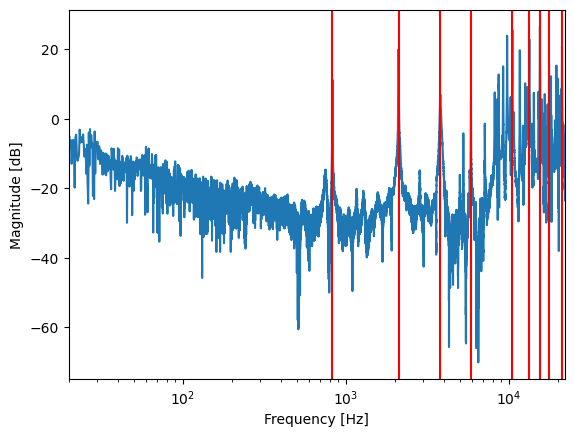

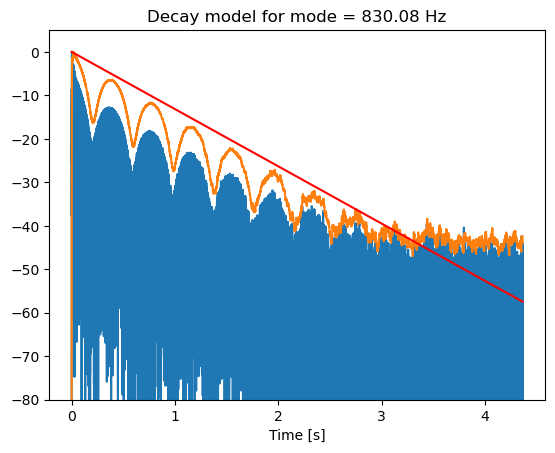

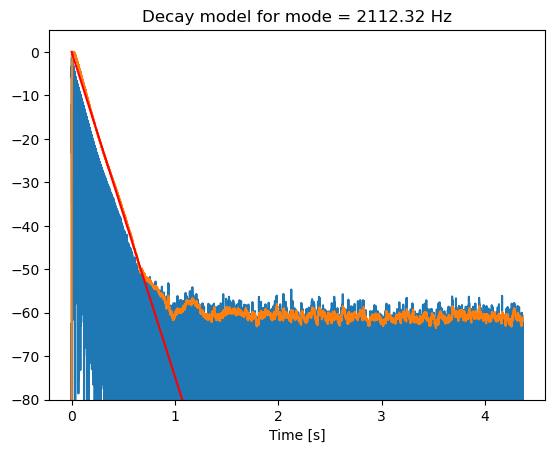

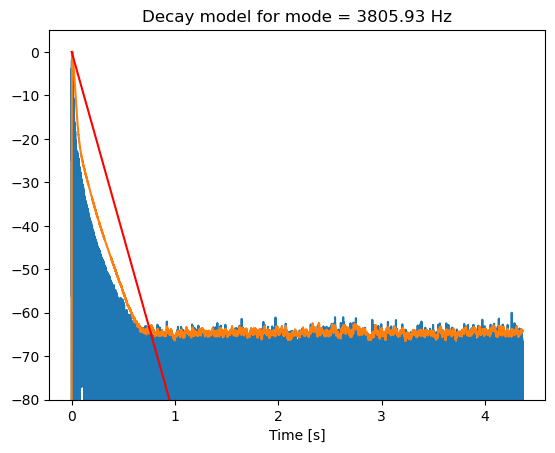

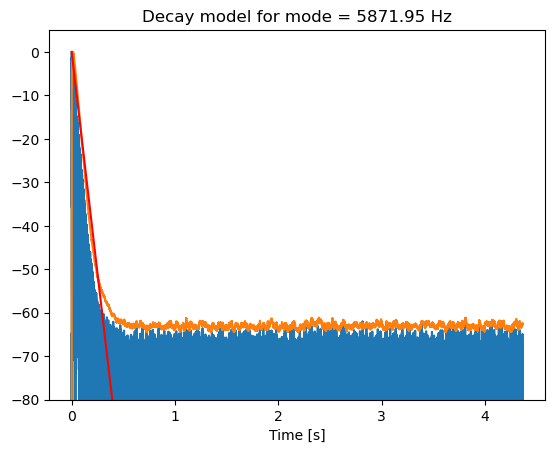

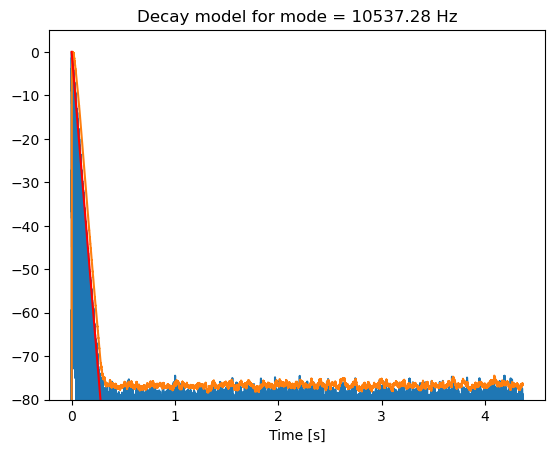

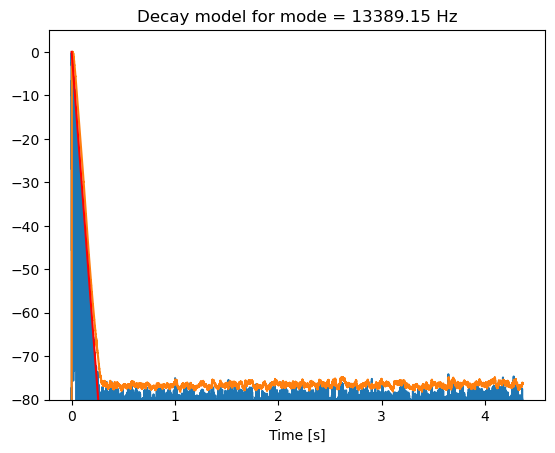

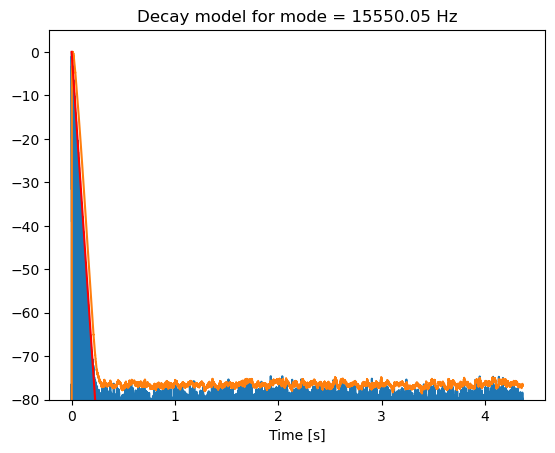

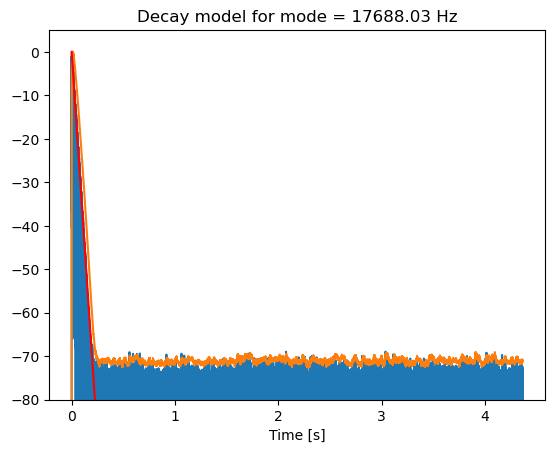

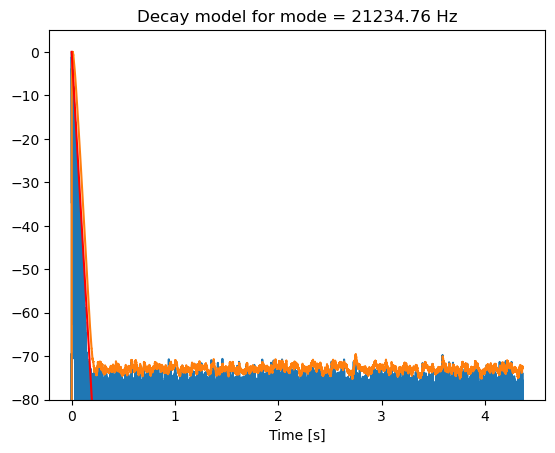

In [5]:
clip = deconvolved[7, :]
freqs = find_freqs(clip, fs, above=20, thresh=5, frac_off=0.1, plot=True)[0]
plt.show()
dampings, damp_freqs = get_dampings(clip, fs, above=20, thresh=5, frac_off=0.1, plot=True)
plt.show()

In [6]:
print(freqs)

[  830.0755326   2112.3153462   3805.92610983  5871.94790065
 10537.28407322 13389.15042541 15550.05108715 17688.03414723
 21234.76218214]


In [7]:
grid = np.zeros((15, 362, damp_freqs.shape[0]), dtype=np.float32)
for j in range(grid.shape[1]):
#     print(j)
    offset = j*grid.shape[0]
    for i in range(grid.shape[0]):
        X = np.fft.rfft(deconvolved[offset+i, 0:fs])
#         f = np.linspace(0, fs/2, num=len(X))
        for k, f_test in enumerate(damp_freqs):
            grid[i, j, k] = 20 * np.log10(np.abs(X[round(damp_freqs[k])]))

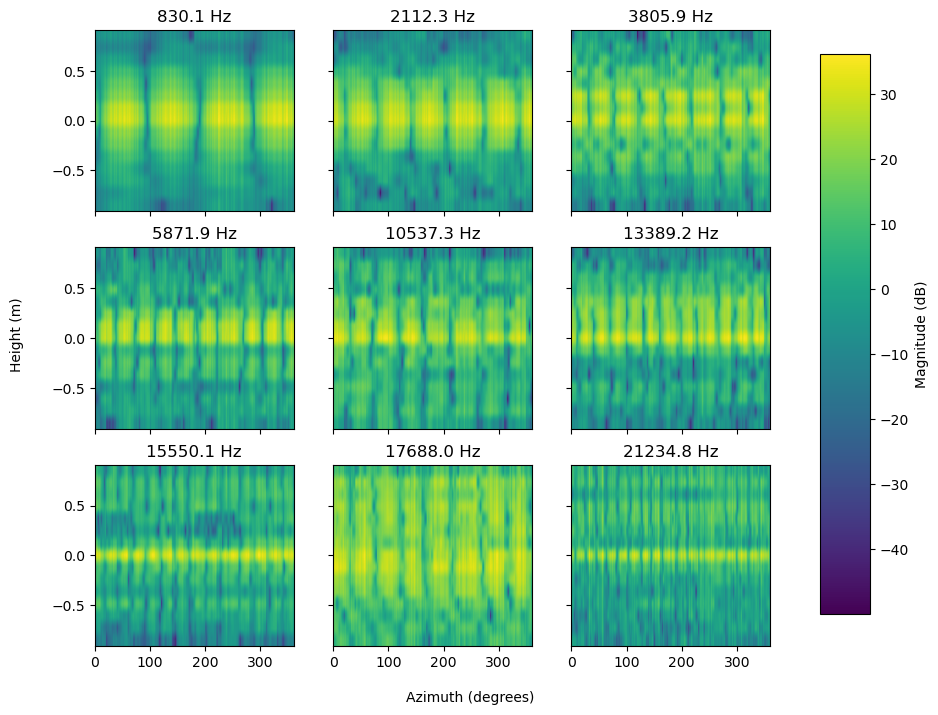

In [8]:
freq_ind = 5
mic_bar_length = 1890 - 70
mic_z = np.linspace(-(mic_bar_length/2), mic_bar_length/2, 15) / 1000

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True) 
for i in range(damp_freqs.shape[0]):
    im = axes[i//3, i%3].imshow(grid[:, 0::1, i], origin='lower', extent=(0, 360, mic_z[0],mic_z[-1]), aspect='auto')
#     axes[i//3, i%3].ylabel('Height (m)')
#     axes[i//3, i%3].xlabel('Azimuth (degrees)')
#     cbar = plt.colorbar()
#     cbar.set_label('Magnitude (dB)')
    axes[i//3, i%3].title.set_text('%.1f Hz'%damp_freqs[i])
fig.text(0.04, 0.5, 'Height (m)', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Azimuth (degrees)', ha='center')
fig.set_size_inches(10, 8)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Magnitude (dB)', rotation=90)
plt.show()

# Symmetry experiments

Symmetric mean: 57.09
Random azimuth mean: 66.13


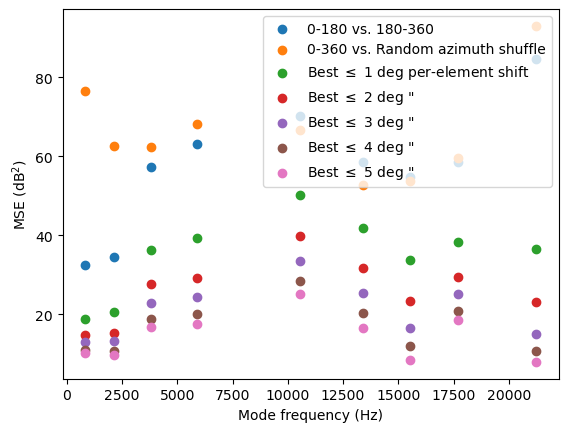

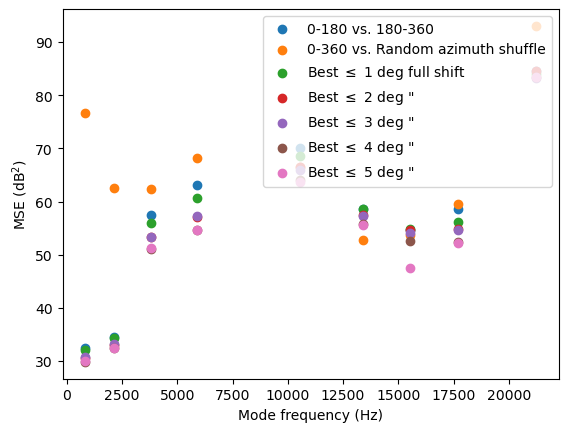

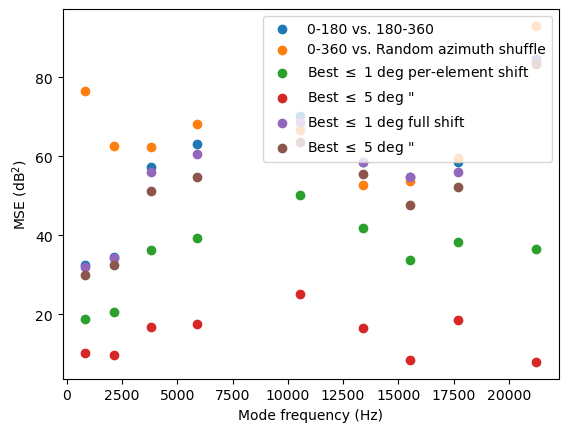

In [21]:
freq_inds = np.arange(grid.shape[2])
first_half = grid[:, :181, freq_inds]
second_half = grid[:, 181:, freq_inds]
print('Symmetric mean: %0.2f'%np.mean(np.square(first_half - second_half)))
grid_shuffled = grid[:, np.random.permutation(np.arange(362)), :]
print('Random azimuth mean: %0.2f'%np.mean(np.square(grid[:, :, freq_inds] - grid_shuffled[:, :, freq_inds])))

first_half_shifts_1_degree = np.stack((grid[:, :179, freq_inds],
                                    grid[:, 1:180, freq_inds],
                                    grid[:, 2:181, freq_inds]), axis=3)

first_half_shifts_2_degree = np.stack((grid[:, :178, freq_inds],
                                grid[:, 1:179, freq_inds],
                                grid[:, 2:180, freq_inds],
                                grid[:, 3:181, freq_inds],
                                grid[:, 4:182, freq_inds]), axis=3)
first_half_shifts_3_degree = np.stack((grid[:, :177, freq_inds],
                                grid[:, 1:178, freq_inds],
                                grid[:, 2:179, freq_inds],
                                grid[:, 3:180, freq_inds],
                                grid[:, 4:181, freq_inds],
                                grid[:, 5:182, freq_inds],
                                grid[:, 6:183, freq_inds]), axis=3)
first_half_shifts_4_degree = np.stack((grid[:, :176, freq_inds],
                                grid[:, 1:177, freq_inds],
                                grid[:, 2:178, freq_inds],
                                grid[:, 3:179, freq_inds],
                                grid[:, 4:180, freq_inds],
                                grid[:, 5:181, freq_inds],
                                grid[:, 6:182, freq_inds],
                                grid[:, 7:183, freq_inds],
                                grid[:, 8:184, freq_inds]), axis=3)
first_half_shifts_5_degree = np.stack((grid[:, :175, freq_inds],
                                grid[:, 1:176, freq_inds],
                                grid[:, 2:177, freq_inds],
                                grid[:, 3:178, freq_inds],
                                grid[:, 4:179, freq_inds],
                                grid[:, 5:180, freq_inds],
                                grid[:, 6:181, freq_inds],
                                grid[:, 7:182, freq_inds],
                                grid[:, 8:183, freq_inds],
                                grid[:, 9:184, freq_inds],
                                grid[:, 10:185, freq_inds]), axis=3)


plt.scatter(damp_freqs, np.mean(np.square(first_half - second_half), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.square(grid - grid_shuffled), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=3), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_2_degree - np.expand_dims(second_half[:, 2:180, :], axis=3)), axis=3), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_3_degree - np.expand_dims(second_half[:, 2:179, :], axis=3)), axis=3), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_4_degree - np.expand_dims(second_half[:, 3:179, :], axis=3)), axis=3), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_5_degree - np.expand_dims(second_half[:, 3:178, :], axis=3)), axis=3), axis=(0,1)))
# plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=(0,1)), axis=1))
# plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_3_degree - np.expand_dims(second_half[:, 2:179, :], axis=3)), axis=(0,1)), axis=1))
plt.legend(('0-180 vs. 180-360', '0-360 vs. Random azimuth shuffle',
            'Best $\leq$ 1 deg per-element shift',
            'Best $\leq$ 2 deg "',
            'Best $\leq$ 3 deg "',
            'Best $\leq$ 4 deg "',
            'Best $\leq$ 5 deg "',
            # '0-180 Best 1 degree full shift vs. 181-359',
            '0-180 Best 3 degree full shift vs. 182-359',
           ), loc='upper right')
plt.xlabel('Mode frequency (Hz)')
plt.ylabel('MSE (dB$^2$)')
plt.show()

plt.scatter(damp_freqs, np.mean(np.square(first_half - second_half), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.square(grid - grid_shuffled), axis=(0,1)))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=(0,1)), axis=1))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_2_degree - np.expand_dims(second_half[:, 2:180, :], axis=3)), axis=(0,1)), axis=1))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_3_degree - np.expand_dims(second_half[:, 2:179, :], axis=3)), axis=(0,1)), axis=1))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_4_degree - np.expand_dims(second_half[:, 3:179, :], axis=3)), axis=(0,1)), axis=1))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_5_degree - np.expand_dims(second_half[:, 3:178, :], axis=3)), axis=(0,1)), axis=1))
# plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=(0,1)), axis=1))
# plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_3_degree - np.expand_dims(second_half[:, 2:179, :], axis=3)), axis=(0,1)), axis=1))
plt.legend(('0-180 vs. 180-360', '0-360 vs. Random azimuth shuffle',
            'Best $\leq$ 1 deg full shift',
            'Best $\leq$ 2 deg "',
            'Best $\leq$ 3 deg "',
            'Best $\leq$ 4 deg "',
            'Best $\leq$ 5 deg "',
            # '0-180 Best 1 degree full shift vs. 181-359',
            '0-180 Best 3 degree full shift vs. 182-359',
           ), loc='upper right')
plt.xlabel('Mode frequency (Hz)')
plt.ylabel('MSE (dB$^2$)')
plt.show()

plt.scatter(damp_freqs, np.mean(np.square(first_half - second_half), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.square(grid - grid_shuffled), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=3), axis=(0,1)))
plt.scatter(damp_freqs, np.mean(np.min(np.square(first_half_shifts_5_degree - np.expand_dims(second_half[:, 3:178, :], axis=3)), axis=3), axis=(0,1)))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=(0,1)), axis=1))
plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_5_degree - np.expand_dims(second_half[:, 3:178, :], axis=3)), axis=(0,1)), axis=1))
# plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_1_degree - np.expand_dims(second_half[:, 1:180, :], axis=3)), axis=(0,1)), axis=1))
# plt.scatter(damp_freqs, np.min(np.mean(np.square(first_half_shifts_3_degree - np.expand_dims(second_half[:, 2:179, :], axis=3)), axis=(0,1)), axis=1))
plt.legend(('0-180 vs. 180-360', '0-360 vs. Random azimuth shuffle',
            'Best $\leq$ 1 deg per-element shift',
            'Best $\leq$ 5 deg "',
            'Best $\leq$ 1 deg full shift',
            'Best $\leq$ 5 deg "',
           ), loc='upper right')
plt.xlabel('Mode frequency (Hz)')
plt.ylabel('MSE (dB$^2$)')
plt.show()

# Interpolation experiments

### Best interpolation method

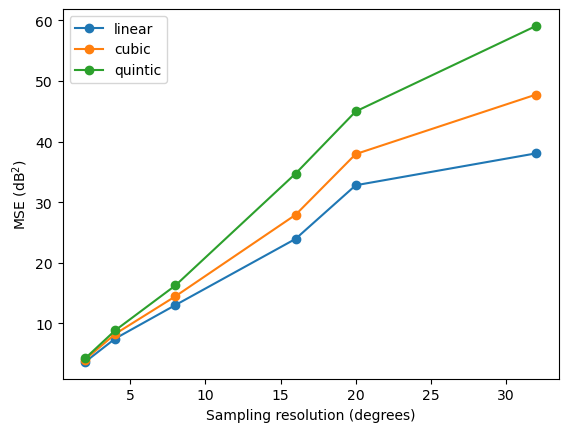

In [10]:
xi = np.concatenate((np.arange(181), (np.arange(181) + 180)))
yi = mic_z

resolutions = np.array([2, 4, 8, 16, 20, 32])
methods = ('linear', 'cubic', 'quintic')
for method in methods:
    results = np.zeros((resolutions.shape[0], damp_freqs.shape[0]))
    for i, r in enumerate(resolutions):
        for j in range(damp_freqs.shape[0]):
            interp = interp2d(xi[0::r], yi, grid[:, 0::r, j], kind=method)
            interpGrid = interp(xi, yi)
            results[i, j] = np.mean(np.square(interpGrid - grid[:, :, j]))
    plt.plot(resolutions, np.mean(results, axis=1), 'o-')
plt.ylabel('MSE (dB$^2$)')
plt.xlabel('Sampling resolution (degrees)')
plt.legend(methods)
plt.show()

### Interpolation resolution

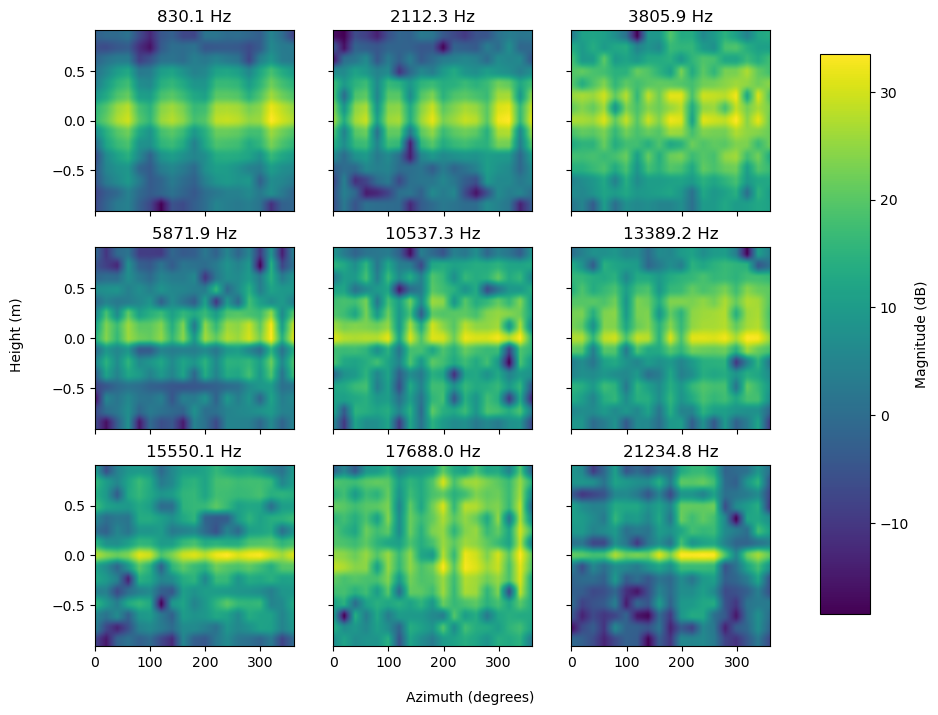

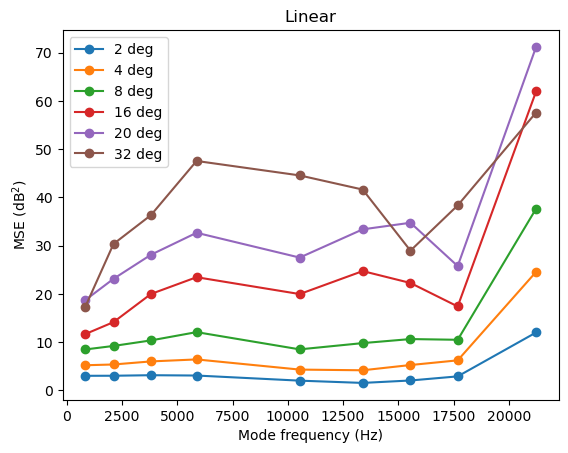

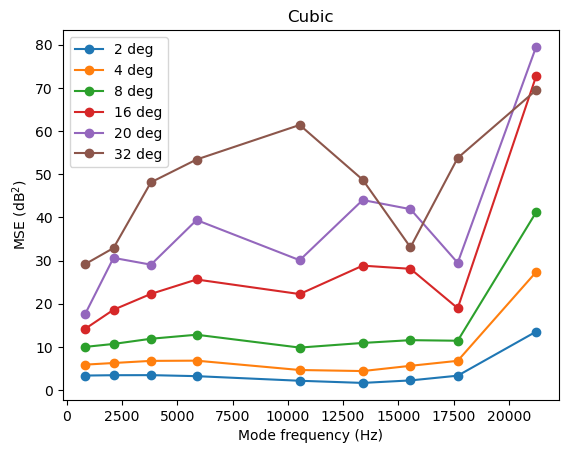

In [22]:
res = 20
xi = np.concatenate((np.arange(181), (np.arange(181) + 180)))
yi = mic_z
freq_ind = 6

# interp = interp2d(xi[0::res], yi, grid[:, 0::res, freq_ind], kind='linear')
# interpGrid = interp(xi, yi)

# fig, axes = plt.subplots(1, 2, sharex=True, sharey=True) 
# axes[0].imshow(interpGrid, origin='lower', extent=(0, 360, mic_z[0],mic_z[-1]), aspect='auto')
# axes[0].ylabel('Height (m)')
# axes[0].xlabel('Azimuth (degrees)')
# cbar = plt.colorbar()
# cbar.set_label('Magnitude (dB)')
# axes[0].title('%.2f Hz Interpolated'%damp_freqs[freq_ind])
# # plt.show()

# axes[1].imshow(grid[:, :, freq_ind], origin='lower', extent=(0, 360, mic_z[0],mic_z[-1]), aspect='auto')
# axes[1].ylabel('Height (m)')
# axes[1].xlabel('Azimuth (degrees)')
# cbar = plt.colorbar()
# cbar.set_label('Magnitude (dB)')
# axes[1].title('%.2f Hz Original'%damp_freqs[freq_ind])
# plt.show()

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True) 
for i in range(damp_freqs.shape[0]):
    interp = interp2d(xi[0::res], yi, grid[:, 0::res, i], kind='linear')
    interpGrid = interp(xi, yi)
    im = axes[i//3, i%3].imshow(interpGrid, origin='lower', extent=(0, 360, mic_z[0],mic_z[-1]), aspect='auto')
#     axes[i//3, i%3].ylabel('Height (m)')
#     axes[i//3, i%3].xlabel('Azimuth (degrees)')
#     cbar = plt.colorbar()
#     cbar.set_label('Magnitude (dB)')
    axes[i//3, i%3].title.set_text('%.1f Hz'%damp_freqs[i])
fig.text(0.04, 0.5, 'Height (m)', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Azimuth (degrees)', ha='center')
fig.set_size_inches(10, 8)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Magnitude (dB)', rotation=90)
plt.show()

resolutions = np.array([2, 4, 8, 16, 20, 32])
results = np.zeros((resolutions.shape[0], damp_freqs.shape[0]))
for i, r in enumerate(resolutions):
    for j in range(damp_freqs.shape[0]):
        interp = interp2d(xi[0::r], yi, grid[:, 0::r, j], kind='linear')
        interpGrid = interp(xi, yi)
        results[i, j] = np.mean(np.square(interpGrid - grid[:, :, j]))
    plt.plot(damp_freqs, results[i, :], 'o-')
plt.ylabel('MSE (dB$^2$)')
plt.xlabel('Mode frequency (Hz)')
plt.legend(['%i deg'%r for r in resolutions])
plt.title('Linear')
plt.show()
resolutions = np.array([2, 4, 8, 16, 20, 32])
results = np.zeros((resolutions.shape[0], damp_freqs.shape[0]))
for i, r in enumerate(resolutions):
    for j in range(damp_freqs.shape[0]):
        interp = interp2d(xi[0::r], yi, grid[:, 0::r, j], kind='cubic')
        interpGrid = interp(xi, yi)
        results[i, j] = np.mean(np.square(interpGrid - grid[:, :, j]))
    plt.plot(damp_freqs, results[i, :], 'o-')
plt.ylabel('MSE (dB$^2$)')
plt.xlabel('Mode frequency (Hz)')
plt.legend(['%i deg'%r for r in resolutions])
plt.title('Cubic')
plt.show()